In [1]:
import tensorflow as tf

In [3]:
# !pip install -U tensorflow_datasets

     |████████████████████████████████| 4.0 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 9.7 MB/s  eta 0:00:01
     |████████████████████████████████| 829 kB 31.7 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 7.0 MB/s  eta 0:00:01
     |████████████████████████████████| 207 kB 28.6 MB/s eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21494 sha256=80c25a90404fd84903581da5753877b82813751d07dc2ff0ef619bfbf29b95e6
  Stored in directory: /Users/rachel.lund/Library/Caches/pip/wheels/54/aa/01/724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=8cc2e67834661a8e997872fabb5ffaa5fb123ea25226c270112c5702a54fd802
  Stored in directory: /Users/rachel.lund/Library/Caches/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built promise future
ERROR: After October 2020 you may experience errors when installin

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [22]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
#--- load data

dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [7]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [9]:
#--- normalize pixels to between 0 and 1

def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

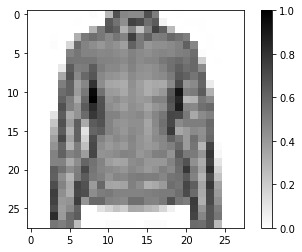

In [12]:
#--- plot an image

# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

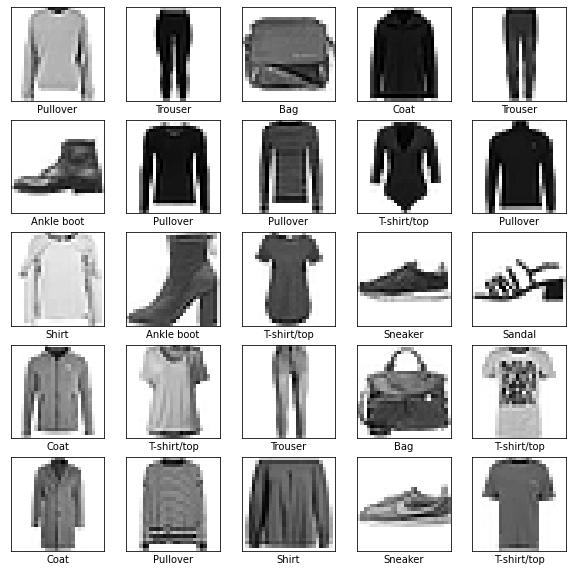

In [13]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

### Simple model

In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [46]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5


In [18]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.3649 - accuracy: 0.8723
Accuracy on test dataset: 0.8723000288009644


In [19]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [20]:
predictions[0]

array([1.9107058e-05, 1.7397066e-06, 3.4341007e-02, 4.1753856e-06,
       9.5590353e-01, 4.9339650e-11, 9.7296359e-03, 1.6794097e-09,
       7.4921672e-07, 2.3256613e-08], dtype=float32)

In [21]:
np.argmax(predictions[0])

4

In [22]:
test_labels[0]

4

In [23]:
class_names[4]

'Coat'

In [24]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

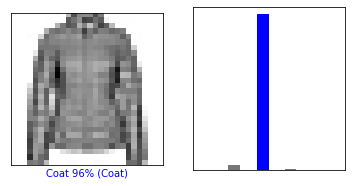

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

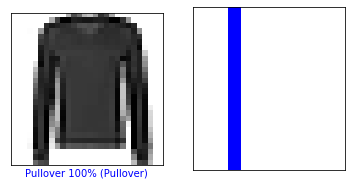

In [26]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

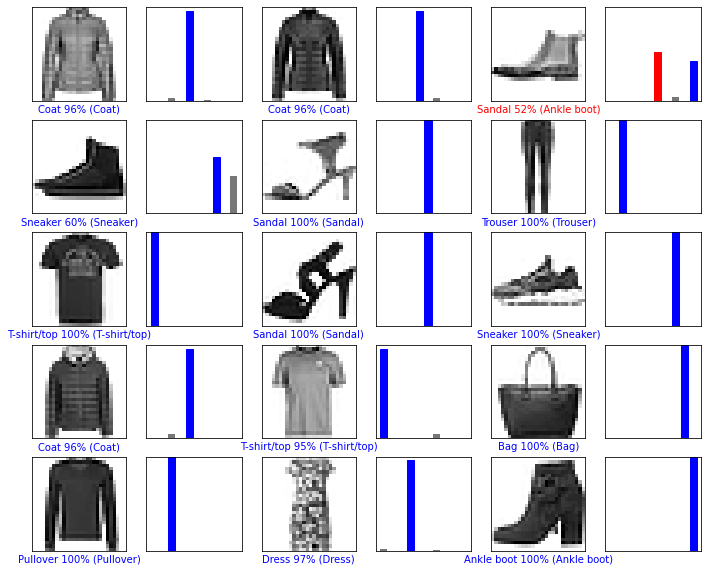

In [27]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [28]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [29]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [30]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.9107056e-05 1.7397048e-06 3.4341000e-02 4.1753933e-06 9.5590341e-01
  4.9339737e-11 9.7296443e-03 1.6794095e-09 7.4921667e-07 2.3256609e-08]]


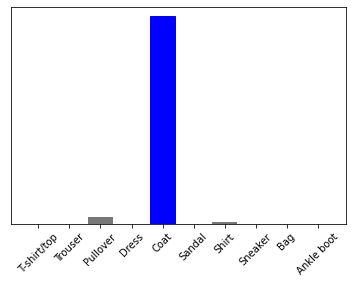

In [31]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [32]:
np.argmax(predictions_single[0])

4

### CNN

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [12]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [13]:
train_dataset

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

In [14]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 29s 14ms/step - loss: 0.3884 - accuracy: 0.8603
Epoch 2/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.2528 - accuracy: 0.9077
Epoch 3/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2076 - accuracy: 0.9239
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1787 - accuracy: 0.9337
Epoch 5/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1547 - accuracy: 0.9428
Epoch 6/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1295 - accuracy: 0.9527
Epoch 7/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1063 - accuracy: 0.9614
Epoch 8/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0928 - accuracy: 0.9657
Epoch 9/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0756 - accuracy: 0.9730
Epoch 10/10
1875/1875 [==============================] - 28s 15m

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.3281 - accuracy: 0.9159
Accuracy on test dataset: 0.9158999919891357


In [16]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [17]:
predictions[0]

array([1.4369284e-08, 6.1168154e-12, 2.5174005e-03, 7.1770707e-11,
       8.9988643e-01, 2.2558569e-10, 9.7595938e-02, 8.7650900e-09,
       2.0384041e-07, 4.9212074e-09], dtype=float32)

In [18]:
np.argmax(predictions[0])

4

In [19]:
test_labels[0]

4

In [20]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

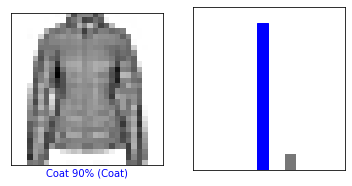

In [21]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)